In [1]:
import pyroomacoustics as pra
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from src.file_io import load_signal_from_wav
from src.visualization_tools import plot_music_spectra
from lib.custom import create_doa_object
from generate_acoustic_sim import calculate_angles

np.random.seed(0)

In [2]:
def run_sevd_music(room ,mic_positions, num_src, ans):
    room.simulate()
    simulated_signals = room.mic_array.signals

    window_size = 512
    hop_size = window_size // 2

    doa = create_doa_object(
        method="SEVD",
        source_noise_thresh=100,
        mic_positions=mic_positions,
        fs=room.fs,
        nfft=window_size,
        num_src=num_src,
        output_dir="",
    )

    X = pra.transform.stft.analysis(
        simulated_signals.T, window_size, hop_size, win=np.hanning(window_size)
    )
    X = np.swapaxes(X, 2, 0)

    frame_length = 100

    for f in range(0, X.shape[2], frame_length // 4):
        xs = X[:, :, f : f + frame_length]
        doa.locate_sources(xs, None, freq_range=[300, 3500], auto_identify=True)
    plot_music_spectra(doa, None, highlight_angles=ans)


def create_room():
    room_dim = [10, 6]
    corners = np.array([[room_dim[0] / 2, 0], [room_dim[0] / 2, room_dim[1]], [-room_dim[0] / 2, room_dim[1]], [-room_dim[0] / 2, 0]]).T
    room = pra.Room.from_corners(corners, fs=16000, max_order=0)

    # 音源の位置を定義
    source_positions = np.array([[-4, 0.5], [-2, 0.8], [0.5, 0.3], [3.7, 1]])

    # 音源を部屋に追加
    signal = load_signal_from_wav("../data/voice/9.wav", room.fs)
    samples_per_source = len(signal) // len(source_positions)
    for i, pos in enumerate(source_positions):
        room.add_source(pos, signal=signal[samples_per_source * i:samples_per_source * (i + 1)])
    return room, len(source_positions)


ans = calculate_angles([[-4, 0.5], [-2, 0.8], [0.5, 0.3], [3.7, 1]], [0, 5])

線状アレイ

(<Figure size 640x480 with 1 Axes>, <Axes: >)

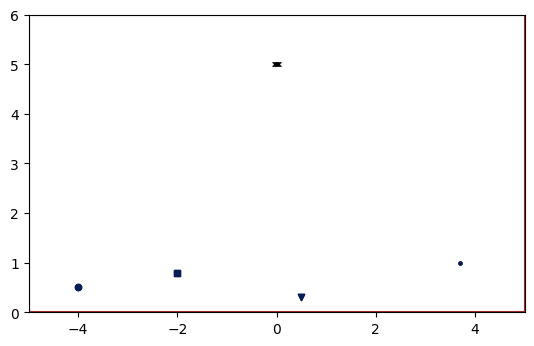

In [3]:
room, num_src = create_room()

# マイクロホンアレイの開始位置
start_pos = -0.045

# 10個のマイクロホンアレイの位置を計算
mic_positions = np.array([[start_pos + 0.01 * i, 5.0] for i in range(10)]).T

# マイクロホンアレイを部屋に追加
mic_array = pra.MicrophoneArray(mic_positions, room.fs)
room.add_microphone_array(mic_array)

room.plot()

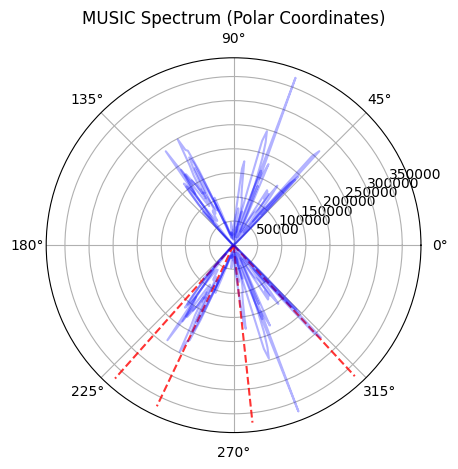

In [4]:
run_sevd_music(room ,mic_positions, num_src - 2, ans)

円状アレイ

(<Figure size 640x480 with 1 Axes>, <Axes: >)

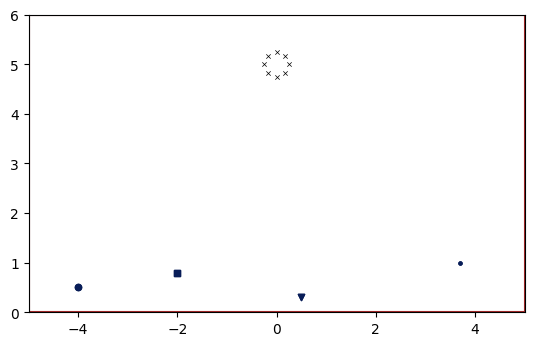

In [5]:
room, num_src = create_room()

mic_positions = pra.circular_2D_array(center=(0, 5), M=8, phi0=0, radius=0.25)

# マイクロホンアレイを部屋に追加
mic_array = pra.MicrophoneArray(mic_positions, room.fs)
room.add_microphone_array(mic_array)

room.plot()

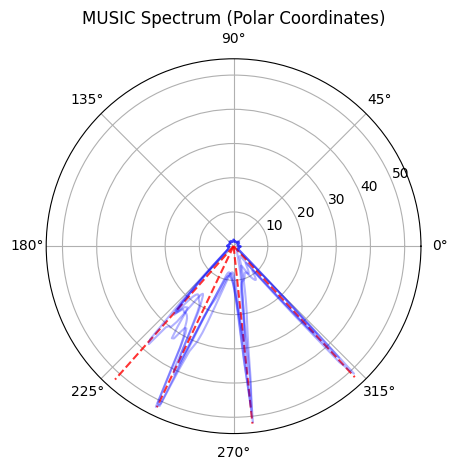

In [6]:
run_sevd_music(room ,mic_positions, num_src - 2, ans)

半球状アレイ

(<Figure size 640x480 with 1 Axes>, <Axes: >)

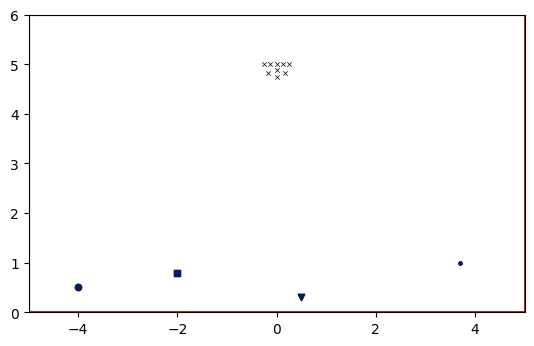

In [7]:
room, num_src = create_room()

center = (0, 5)
radius = 0.25
mic_positions = pra.circular_2D_array(center=center, M=8, phi0=0, radius=radius)
# y座標が2より大きいマイクロホンアレイを削除
mic_positions = np.delete(mic_positions, np.where(mic_positions[1] > center[1]), axis=1)
# 新しい座標を既存の配列に追加
new_points = np.array([
    [center[0] - radius / 2, center[1]],
    center,
    [center[0] + radius / 2, center[1]],
    [center[0], center[1] - radius / 2],
]).T
mic_positions = np.concatenate((mic_positions, new_points), axis=1)

# マイクロホンアレイを部屋に追加
mic_array = pra.MicrophoneArray(mic_positions, room.fs)
room.add_microphone_array(mic_array)

room.plot()

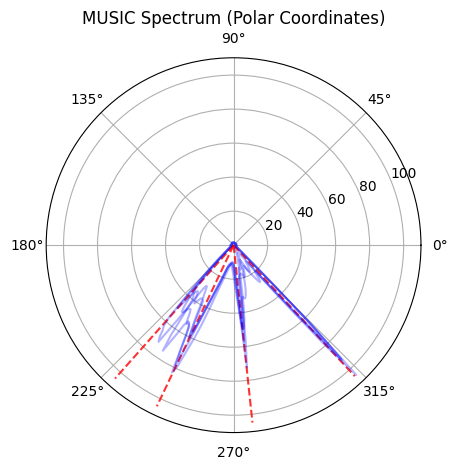

In [8]:
run_sevd_music(room ,mic_positions, num_src - 2, ans)

radius: 0.05


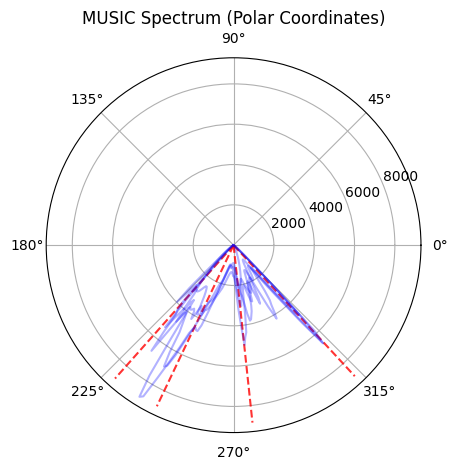

radius: 0.10


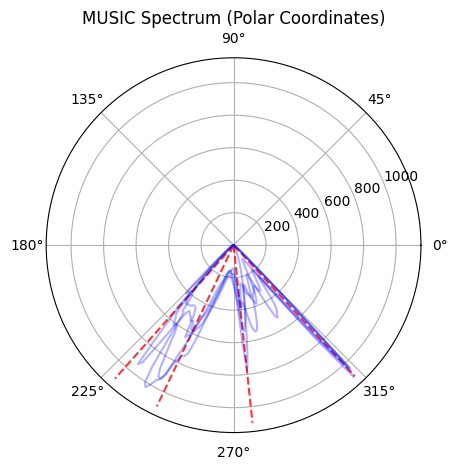

radius: 0.15


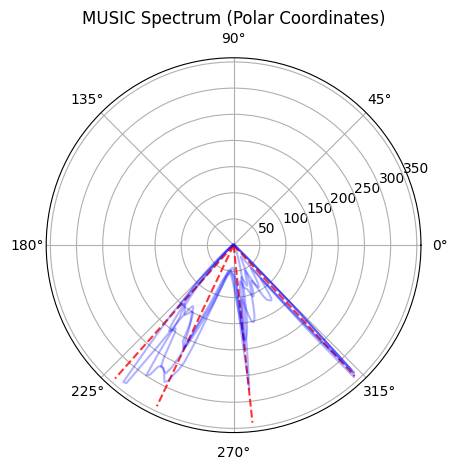

radius: 0.20


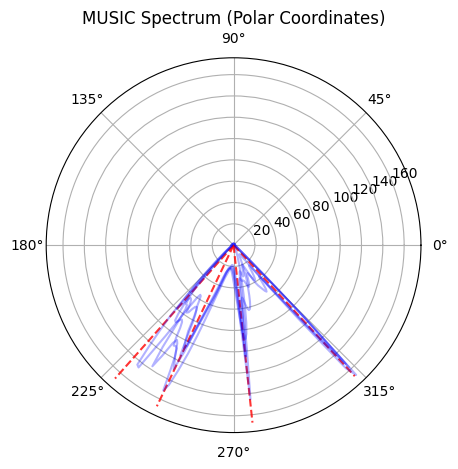

radius: 0.25


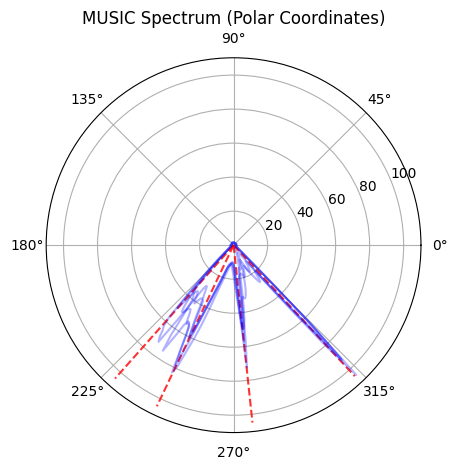

radius: 0.30


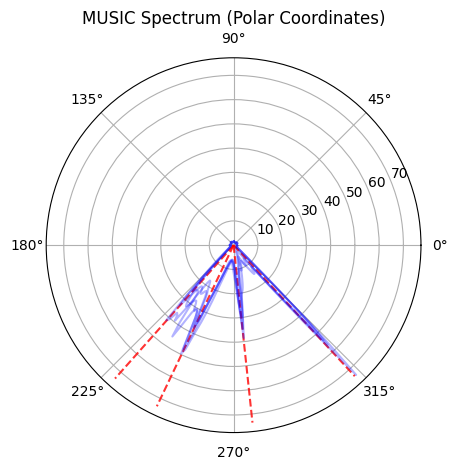

radius: 0.35


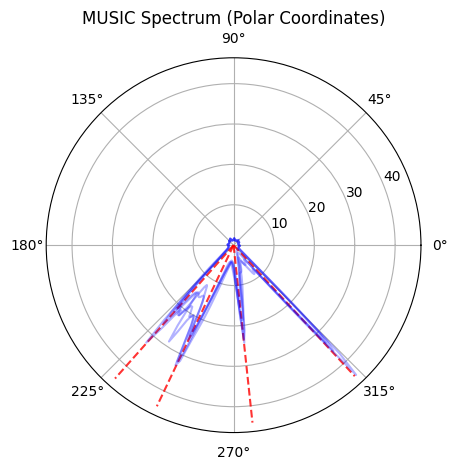

radius: 0.40


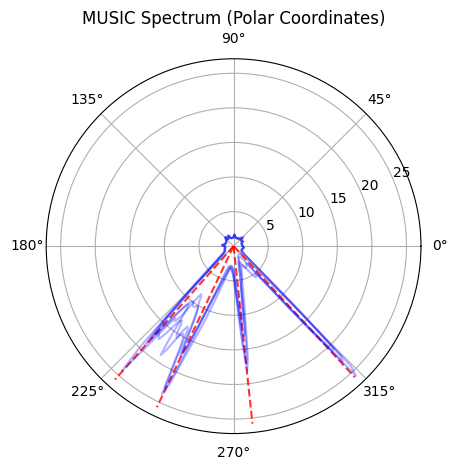

radius: 0.45


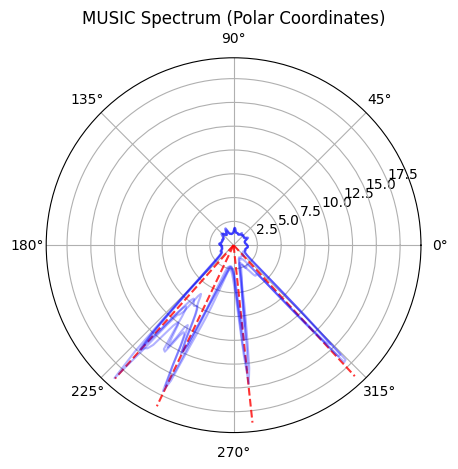

radius: 0.50


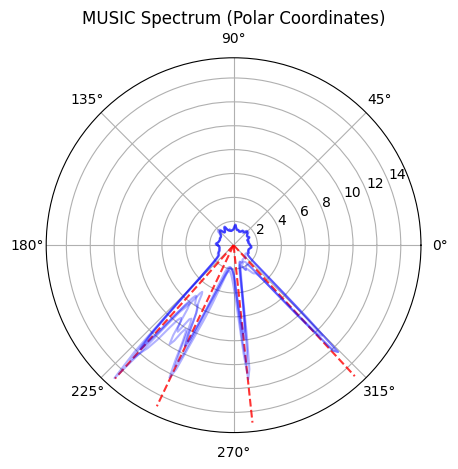

In [9]:
for r in np.arange(0.05, 0.51, 0.05):
    print(f"radius: {r:.2f}")
    room, num_src = create_room()

    center = (0, 5)
    mic_positions = pra.circular_2D_array(center=center, M=8, phi0=0, radius=r)
    # y座標が2より大きいマイクロホンアレイを削除
    mic_positions = np.delete(mic_positions, np.where(mic_positions[1] > center[1]), axis=1)
    # 新しい座標を既存の配列に追加
    new_points = np.array([
        [center[0] - r / 2, center[1]],
        center,
        [center[0] + r / 2, center[1]],
        [center[0], center[1] - r / 2],
    ]).T
    mic_positions = np.concatenate((mic_positions, new_points), axis=1)

    # マイクロホンアレイを部屋に追加
    mic_array = pra.MicrophoneArray(mic_positions, room.fs)
    room.add_microphone_array(mic_array)

    run_sevd_music(room ,mic_positions, num_src - 2, ans)